In [61]:


import _init_paths
from PIL import Image
import numpy as np
import cv2
import random
import copy

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e  import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown
from vcl.models.trackers import *
from vcl.utils import *
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

import matplotlib.pyplot as plt
%matplotlib inline

target_image_size = 256

samples = []
with open('/home/lr/dataset/YouTube-VOS/2018/train/test_records.txt', 'r') as f:
    for line in f.readlines():
        name, frame_idx, pixel_idx = line.strip('\n').split()
        samples.append([name, int(frame_idx), int(pixel_idx)])
        
visualizer = Correspondence_Visualizer(mode='flow', radius=6)
visualizer_hr = Correspondence_Visualizer(mode='flow', scale=64, radius=6)

output_dir = '/home/lr/project/vcl_output/vis_flow'

if os.path.exists(output_dir): os.makedirs(output_dir, exist_ok=True)



def main(x1, x2, model, frame1, frame2, gt):
    enc1 = model.backbone(x1.cuda())
    enc2 = model.backbone(x2.cuda())
    plt = visualizer.visualize([enc1, enc2], [x1, x2], [frame1, frame2], gt)
    # visualize_correspondence_quant(enc1, enc2, sample_idx, frame1, frame2, scale=32)
    return plt

def main_hr(x1, x2, model, frame1, frame2, gt):
    enc1 = model.backbone(x1.cuda())
    enc2 = model.backbone(x2.cuda())
    plt = visualizer_hr.visualize([enc1, enc2], [x1, x2], [frame1, frame2], gt)
    return plt

In [62]:
## sample frame
import os.path as osp
import glob


# sample_video_idx = 92
sample_video_idx = random.randint(0, 300)
sample = {}
sample['frames_path'] = sorted(glob.glob(osp.join('/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages', samples[sample_video_idx][0], '*.jpg')))


frame_idx = samples[sample_video_idx][1]
sample_idx = samples[sample_video_idx][2]
video_name = sample['frames_path'][0].split('/')[-2]


frame1 = cv2.imread(sample['frames_path'][frame_idx])[:,:,::-1]
frame2 = cv2.imread(sample['frames_path'][frame_idx+1])[:,:,::-1]
gt = cv2.imread(sample['frames_path'][frame_idx].replace('JPEGImages', 'Flows_s256'))


frame1 = cv2.resize(frame1, (256,256))
frame2 = cv2.resize(frame2, (256,256))
gt = cv2.resize(gt, (256,256))[:,:,1:].astype(np.float32) / 255 - 0.5


print('sample frames from {}'.format(sample['frames_path'][0]))

x1_rgb = preprocess_(frame1, mode='rgb')
x2_rgb = preprocess_(frame2, mode='rgb')

x1_lab = preprocess_(frame1, mode='lab')
x2_lab = preprocess_(frame2, mode='lab')

sample frames from /home/lr/dataset/YouTube-VOS/2018/train/JPEGImages/4d67c59727/00000.jpg


2022-06-25 15:10:56,542 - vcl - INFO - Loading /home/lr/expdir/VCL/group_stsl_former/mast_d4_l2_pyramid_dis_18/epoch_3200.pth not as torchvision
2022-06-25 15:10:56,543 - vcl - INFO - load checkpoint from local path: /home/lr/expdir/VCL/group_stsl_former/mast_d4_l2_pyramid_dis_18/epoch_3200.pth


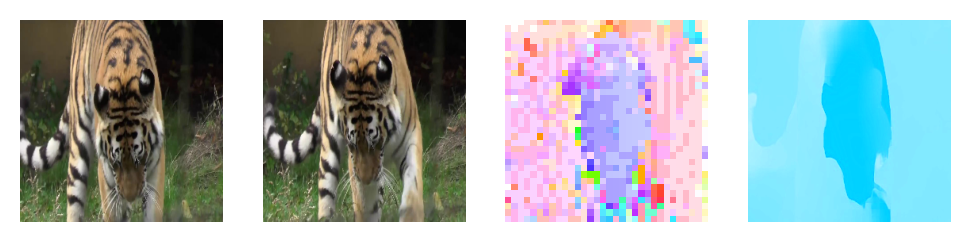

In [63]:

model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 2, 1), out_indices=(2, ), pool_type='none', pretrained='/home/lr/expdir/VCL/group_stsl_former/mast_d4_l2_pyramid_dis_18/epoch_3200.pth', torchvision_pretrain=False),
    test_cfg=dict(),
    train_cfg=dict()
    )


model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model, frame1, frame2, gt)

2022-06-25 15:10:57,058 - vcl - INFO - Loading /home/lr/expdir/VCL/group_stsl_former/mast_d4_l2_base_cos_3/epoch_1600.pth not as torchvision
2022-06-25 15:10:57,058 - vcl - INFO - load checkpoint from local path: /home/lr/expdir/VCL/group_stsl_former/mast_d4_l2_base_cos_3/epoch_1600.pth
2022-06-25 15:10:57,080 - vcl - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: cos_loss.grid



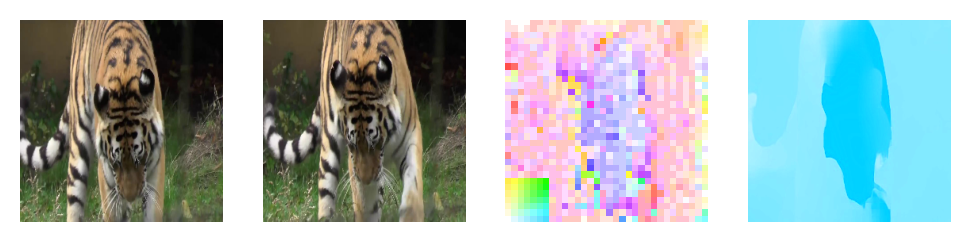

In [64]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(2, ), pool_type='mean', pretrained='/home/lr/expdir/VCL/group_stsl_former/mast_d4_l2_base_cos_3/epoch_1600.pth', torchvision_pretrain=False),
    test_cfg=dict(),
    train_cfg=dict()
    )


model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model, frame1, frame2, gt)

2022-06-25 15:10:57,622 - vcl - INFO - Loading /home/lr/mount/expdir/VCL/group_stsl/temp_res18_d4_l2_rec_concentration/epoch_160.pth not as torchvision
2022-06-25 15:10:57,623 - vcl - INFO - load checkpoint from local path: /home/lr/mount/expdir/VCL/group_stsl/temp_res18_d4_l2_rec_concentration/epoch_160.pth
2022-06-25 15:10:57,645 - vcl - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conc_loss.grid



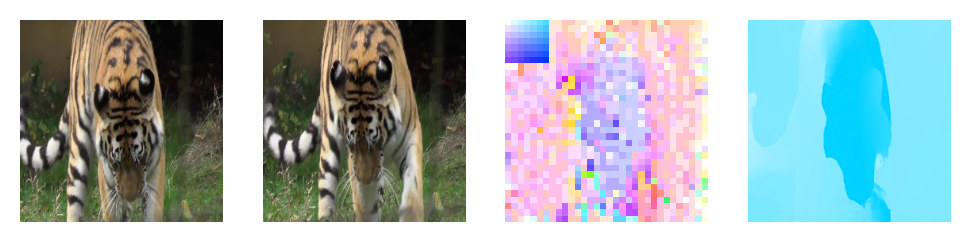

In [65]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 2, 1), out_indices=(2, ), pool_type='none', pretrained='/home/lr/mount/expdir/VCL/group_stsl/temp_res18_d4_l2_rec_concentration/epoch_160.pth', torchvision_pretrain=False),
    test_cfg=dict(),
    train_cfg=dict()
    )


model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model, frame1, frame2, gt)

2022-06-25 15:10:58,223 - vcl - INFO - Loading /home/lr/mount/expdir/VCL/group_stsl/temp_res18_d4_l2_rec_concentration_3/epoch_160.pth not as torchvision
2022-06-25 15:10:58,223 - vcl - INFO - load checkpoint from local path: /home/lr/mount/expdir/VCL/group_stsl/temp_res18_d4_l2_rec_concentration_3/epoch_160.pth
2022-06-25 15:10:58,246 - vcl - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conc_loss.grid



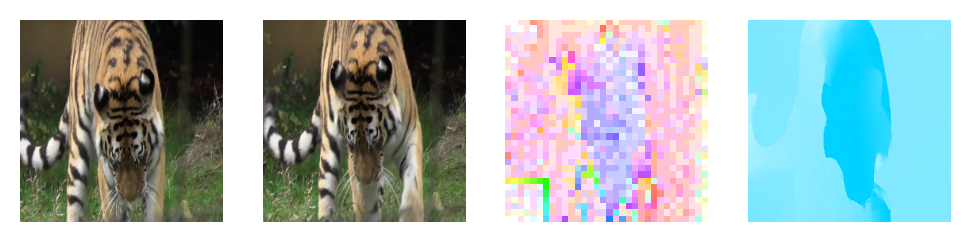

In [66]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 2, 1), out_indices=(2, ), pool_type='none', pretrained='/home/lr/mount/expdir/VCL/group_stsl/temp_res18_d4_l2_rec_concentration_3/epoch_160.pth', torchvision_pretrain=False),
    test_cfg=dict(),
    train_cfg=dict()
    )


model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model, frame1, frame2, gt)